In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:
zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm,num_eigen=11,init_vector=None,num_Lanczos=None,iteration=None,tolerance=0)

In [6]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
steric2 = xr.open_zarr('/swot/SUM02/spencer/steric_inc_mean.zarr')
steric_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_mean.zarr')

eta_eul = steric2.steric-steric_mean.steric

uvel_filtered = vels_filtered.u.isel(time=slice(2,110))
vvel_filtered = vels_filtered.v.isel(time=slice(2,110))
ssh_filtered = eta_filtered.eta.isel(time=slice(2,110))

uvel_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
vvel_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))


#uvel_filtered = uvel_filtered.drop_vars('time')
#vvel_filtered = vvel_filtered.drop_vars('time')
#uvel_unfiltered = uvel_unfiltered.drop_vars('time')
#vvel_unfiltered = vvel_unfiltered.drop_vars('time')
grid = Grid(uvel_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [10]:

f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)

In [11]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=uvel_unfiltered.time.shape[0]
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [7]:
#eul_filtered_vels = u_eul_filtered.rename('u_eulfiltered').to_dataset()
#eul_filtered_vels = eul_filtered_vels.merge(v_eul_filtered.rename('v_eulfiltered'))
#eul_filtered_vels.to_zarr('/swot/SUM03/spencer/time_1/eulfiltered_vels.zarr')

In [12]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
uvel_filtered = uvel_filtered.swap_dims({"i": "x0"})
uvel_filtered = uvel_filtered.swap_dims({"j": "y0"})
vvel_filtered = vvel_filtered.swap_dims({"i": "x0"})
vvel_filtered = vvel_filtered.swap_dims({"j": "y0"})
uvel_unfiltered = uvel_unfiltered.swap_dims({"i": "x0"})
uvel_unfiltered = uvel_unfiltered.swap_dims({"j": "y0"})
vvel_unfiltered = vvel_unfiltered.swap_dims({"i": "x0"})
vvel_unfiltered = vvel_unfiltered.swap_dims({"j": "y0"})

ssh_filtered = ssh_filtered.swap_dims({"i": "x0"})
ssh_filtered = ssh_filtered.swap_dims({"j": "y0"})
ssh_unfiltered = ssh_unfiltered.swap_dims({"i": "x0"})
ssh_unfiltered = ssh_unfiltered.swap_dims({"j": "y0"})

In [15]:
lons, lats = np.meshgrid(uvel_filtered.x0.values, uvel_filtered.y0.values)

In [16]:
def target_area_def(ds_patch,variable_name,center_point=ds_patch.isel(x0=1080,y0=1080)):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [17]:
x_resampled = ufunc_resample((u_eul_filtered.x0*xr.ones_like(u_eul_filtered.isel(time=slice(0,10)))).load())
y_resampled = ufunc_resample((u_eul_filtered.y0*xr.ones_like(u_eul_filtered.isel(time=slice(0,10)))).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [18]:
u_eul_resampled = ufunc_resample(u_eul_filtered.load())
v_eul_resampled = ufunc_resample(v_eul_filtered.load())
u_resampled = ufunc_resample(uvel_filtered.load())
v_resampled = ufunc_resample(vvel_filtered.load())
u_resampled_unfilt = ufunc_resample(uvel_unfiltered.load())
v_resampled_unfilt = ufunc_resample(vvel_unfiltered.load())

eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.load())
eta_resampled = ufunc_resample(ssh_filtered.load())
eta_eul_resampled = ufunc_resample(eta_eul_filtered.load())

KeyboardInterrupt: 

In [23]:
u_eul_resampled = u_eul_resampled.assign_coords(x1=("x1", u_eul_resampled.x1.values)).assign_coords(y1=("y1", u_eul_resampled.y1.values))
v_eul_resampled = v_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
eta_eul_resampled = eta_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
eta_resampled = eta_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
u_resampled_unfilt = u_resampled_unfilt.assign_coords(x1=("x1", u_resampled_unfilt.x1.values)).assign_coords(y1=("y1", u_resampled_unfilt.y1.values))
v_resampled_unfilt = v_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))
eta_resampled_unfilt = eta_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))

In [33]:
with ProgressBar():
    u2_ps = xrft.power_spectrum(u_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps = xrft.power_spectrum(v_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps = xrft.power_spectrum(eta_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps = (u2_ps + v2_ps)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [24]:
with ProgressBar():
    u2_ps_unfilt = xrft.power_spectrum(u_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_unfilt = xrft.power_spectrum(v_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_unfilt = xrft.power_spectrum(eta_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_unfilt = (u2_ps_unfilt + v2_ps_unfilt)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [19]:
with ProgressBar():
    u2_ps_eul = xrft.power_spectrum(u_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_eul = xrft.power_spectrum(v_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_eul = xrft.power_spectrum(eta_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_eul = (u2_ps_eul + v2_ps_eul)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [25]:
windows,_ = xrft.xrft._apply_window(u_eul_resampled, dims=['x1','y1','time'], window_type="hann")

In [26]:
#for torres filter, we should actually compute the fourier transform first
with ProgressBar():
    u2_xs_unfilt = xrft.dft(u_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()#,window=True,window_correction=True
    v2_xs_unfilt = xrft.dft(v_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
kx = v2_xs_unfilt.freq_x1
ky = v2_xs_unfilt.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600
u2_xs_tofilt = u2_xs_unfilt.where(np.abs(u2_xs_unfilt.freq_time)*xr.ones_like(u2_xs_unfilt)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilt = v2_xs_unfilt.where(np.abs(v2_xs_unfilt.freq_time)*xr.ones_like(v2_xs_unfilt)<omegaM[:,:,10]/np.pi/2)
windows,_ = xrft.xrft._apply_window(u_eul_resampled, dims=['x1','y1','time'])
vel_ps_eul_torres = (np.abs(u2_xs_tofilt)**2 + np.abs(v2_xs_tofilt)**2)*0.5/(windows**2).mean()/5825.42222222


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [31]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [39]:
ps_iso = iso_spec(vel_ps)
ps_iso_unfilt = iso_spec(vel_ps_unfilt)
#ps_iso_eul = iso_spec(vel_ps_eul)
#ps_iso_torres = iso_spec(vel_ps_eul_torres)
#eta_iso = iso_spec(eta_ps)
#eta_iso_unfilt = iso_spec(eta_ps_unfilt)
#eta_iso_eul = iso_spec(eta_ps_eul)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [35]:
kr    = ps_iso.kr
omegaM = np.nan*np.ones([kr.shape[0], 11])
for i in range(1,11):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

NameError: name 'ps_iso_unfilt' is not defined

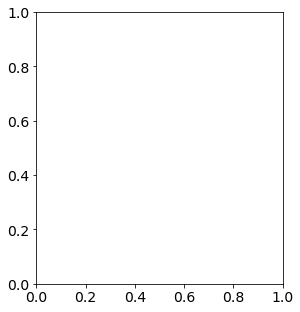

In [37]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-5,0,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.022, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.022, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Filtered using Eulerian method')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.022, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Filtered using Lagrangian method')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq.png')

In [8]:
from matplotlib import ticker, colors
lev_exp = np.linspace(-4,0,17)
lev = np.concatenate([-np.power(10, lev_exp)[-1::-1], np.power(10, lev_exp)])
cs = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso-ps_iso_eul),levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0),cmap='RdBu_r',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.022, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Lagrangian filtered minus Eulerian filtered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)


fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('eul_lag_difference.png')


NameError: name 'kr' is not defined

<xarray.DataArray (freq_time: 90, kr: 129)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001358 ... 0.0001327 0.0001358
  * kr         (kr) float64 0.0 0.002653 0.006041 ... 0.4921 0.496 0.5611

<xarray.DataArray (freq_time: 90, kr: 129)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * freq_time  (freq_time) float64 -0.5 -0.4889 -0.4778 ... 0.4667 0.4778 0.4889
  * kr         (kr) float64 0.0 0.002653 0.006041 ... 0.4921 0.496 0.5611

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


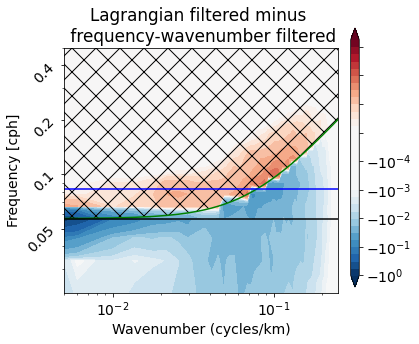

In [90]:
plt.figure(figsize=(6,5))
from matplotlib import ticker, colors
lev_exp = np.linspace(-4,0,17)
lev = np.concatenate([-np.power(10, lev_exp)[-1::-1], np.power(10, lev_exp)])
cs = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso-ps_iso_torres.drop_vars('freq_time').fillna(0)),levels = lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0),cmap='RdBu_r',extend='both')
#plt.colorbar(cs)

plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')


plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.022, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Lagrangian filtered minus \n frequency-wavenumber filtered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

ax = plt.gca()
ax.fill_between(kr, omegaM[:,10]/np.pi/2, y2=np.ones(len(kr)),
                            color = None, alpha = 0,hatch='X')


fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('torres_lag_difference.png')

In [114]:

ps_iso_tofilt = ps_iso_unfilt
ps_iso_tofilt = ps_iso_tofilt.where(ps_iso_tofilt.freq_time*xr.ones_like(ps_iso_tofilt)*3600<omegaM[:,10]/np.pi/2)


eta_iso_tofilt = eta_iso_unfilt
eta_iso_tofilt = eta_iso_tofilt.where(eta_iso_tofilt.freq_time*xr.ones_like(eta_iso_tofilt)*3600<omegaM[:,10]/np.pi/2)


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  app.launch_new_instance()


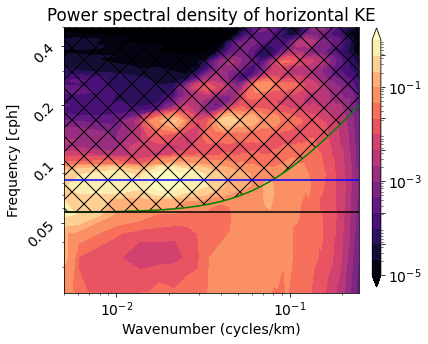

In [40]:
plt.figure(figsize=(6,5))
#plt.subplot(121)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.022, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Power spectral density of horizontal KE')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

ax = plt.gca()
ax.fill_between(kr, omegaM[:,10]/np.pi/2, y2=np.ones(len(kr)),
                            color = None, alpha = 0,hatch='X')

#plt.subplot(122)
#cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_tofilt.fillna(10**-11),lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
#plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim([0.005, 0.25])
#plt.ylim([0.04, 0.5])
#plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
#plt.tight_layout()
#plt.title('FWN filter')
#plt.axhline(-fm/np.pi/2*3600,color='k')
#plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
#plt.yticks(yticks_s,yticks_s,rotation=45)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('torres-style-filter.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  app.launch_new_instance()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: UserWarning: Log scale: values of z <= 0 have been masked


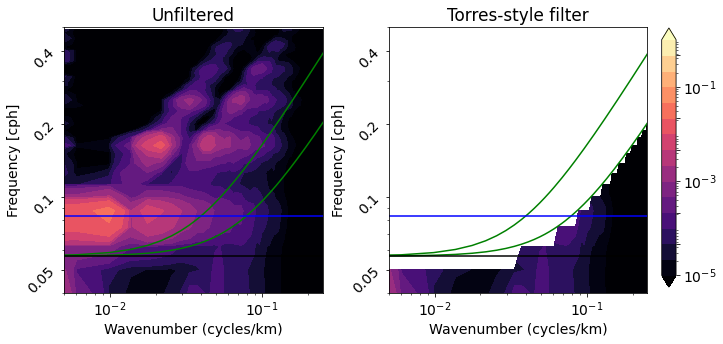

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(121)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*eta_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(122)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*eta_iso_tofilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Torres-style filter')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('torres-style-filter.png')

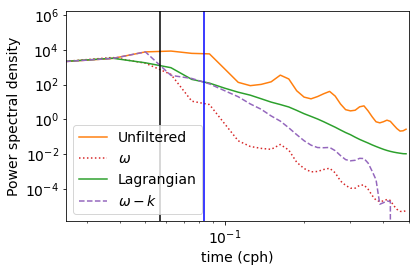

In [253]:
plt.figure(figsize=(6,4))


ps_iso_unfilt.sum('kr').assign_coords(freq_time=ps_iso_unfilt.freq_time*3600).plot(c='tab:orange')
plt.xscale('log')
plt.yscale('log')

ps_iso_eul.sum('kr').assign_coords(freq_time=ps_iso_eul.freq_time*3600).plot(c='tab:red',linestyle =':')
plt.xscale('log')
plt.yscale('log')

ps_iso.sum('kr').assign_coords(freq_time=ps_iso.freq_time*3600).plot(c='tab:green')
plt.xscale('log')
plt.yscale('log')

ps_iso_tofilt.sum('kr').assign_coords(freq_time=ps_iso_tofilt.freq_time*3600).plot(c='tab:purple',linestyle ='--')
plt.xscale('log')
plt.yscale('log')




plt.xlim(0.025,0.5)
plt.ylabel('Power spectral density')

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')

plt.legend(['Unfiltered','$\omega$','Lagrangian','$\omega-k$'],loc='lower left')

plt.tight_layout()
plt.xlabel('time (cph)')

fig=plt.gcf()
fig.savefig('spectrum_all_methods.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  app.launch_new_instance()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:44: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:64: UserWarning: Log scale: values of z <= 0 have been masked


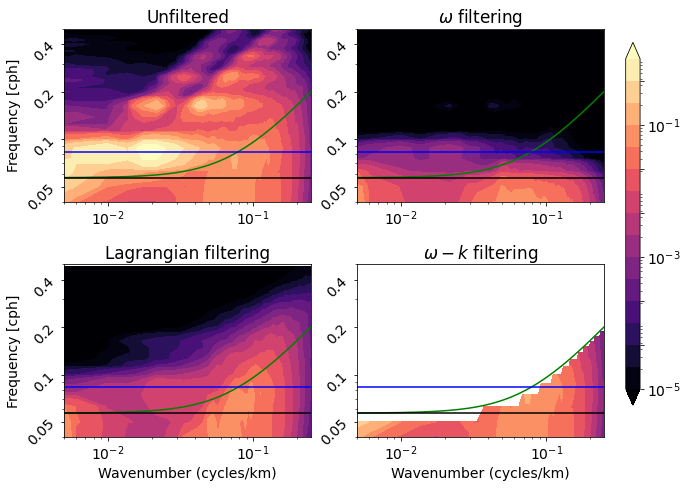

In [251]:
plt.figure(figsize=(10,7))
plt.subplot(221)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(222)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('$\omega$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)


plt.subplot(223)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Lagrangian filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(224)
cs = plt.contourf(kr,omega,np.abs(omega).drop_vars('freq_time')*kr*ps_iso_torres,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('$\omega-k$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)


fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('fwn_all_methods.png')

# Rotary spectrum

In [278]:
z_resampled = u_resampled + 1j* v_resampled
z_resampled_unfilt = u_resampled_unfilt + 1j* v_resampled_unfilt
z_eul_resampled = u_eul_resampled + 1j* v_eul_resampled
with ProgressBar():
    z2_resampled_unfilt = xrft.power_spectrum(z_resampled_unfilt.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
    z2_resampled = xrft.power_spectrum(z_resampled.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
    z2_eul_resampled = xrft.power_spectrum(z_eul_resampled.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
    z2_tofilt_resampled = xrft.power_spectrum(z_resampled_unfilt.chunk({'time':-1}),dim=['time','x1','y1'], window=True,window_correction=True).compute()

[################                        ] | 41% Completed |  0.1s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  2.9s
[################                        ] | 41% Completed |  0.1s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  2.9s
[################                        ] | 41% Completed |  0.1s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  2.7s
[#########                               ] | 23% Completed |  0.1s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  6.2s


In [293]:
kx = z2_tofilt_resampled.freq_x1
ky = z2_tofilt_resampled.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5
z2_tofilt_resampled = z2_tofilt_resampled.where(np.abs(z2_tofilt_resampled.freq_time)*xr.ones_like(z2_tofilt_resampled)<omegaM[:,:,10]/np.pi/2)


In [294]:
spec0=40

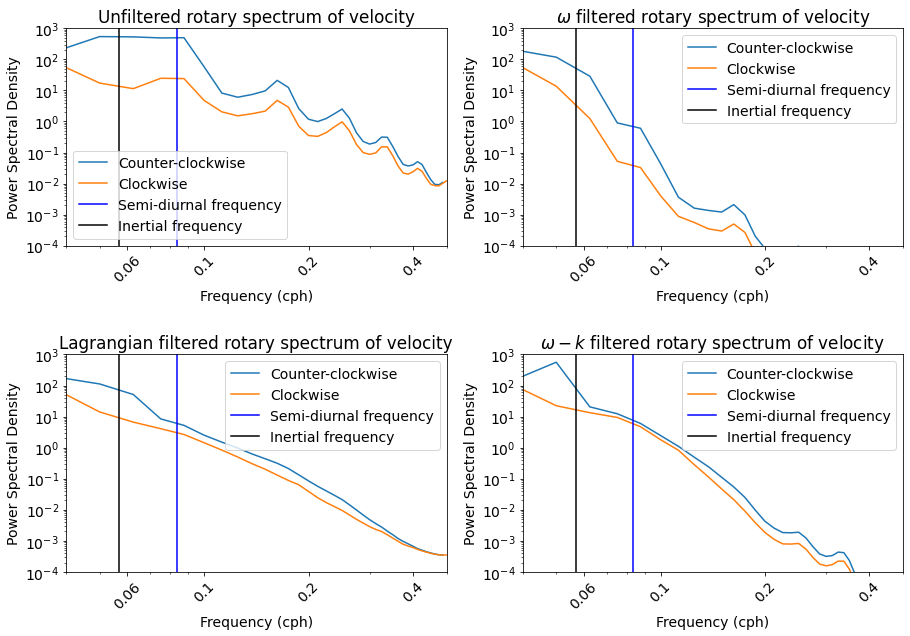

In [302]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]


plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(z2_resampled_unfilt.freq_time[spec0:]*3600,z2_resampled_unfilt.mean(['x1','y1'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_resampled_unfilt.freq_time[spec0::-1]*3600,z2_resampled_unfilt.mean(['x1','y1'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered rotary spectrum of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')


plt.subplot(222)
plt.plot(z2_eul_resampled.freq_time[spec0:]*3600,z2_eul_resampled.mean(['x1','y1'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_eul_resampled.freq_time[spec0::-1]*3600,z2_eul_resampled.mean(['x1','y1'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('$\omega$ filtered rotary spectrum of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')


plt.subplot(223)
plt.plot(z2_resampled.freq_time[spec0:]*3600,z2_resampled.mean(['x1','y1'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_resampled.freq_time[spec0::-1]*3600,z2_resampled.mean(['x1','y1'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered rotary spectrum of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(224)
plt.plot(z2_tofilt_resampled.sum(['freq_x1','freq_y1']).freq_time[spec0:]*3600,z2_tofilt_resampled.sum(['freq_x1','freq_y1'])[spec0:]/512**2,label='Counter-clockwise')
plt.plot(-z2_tofilt_resampled.sum(['freq_x1','freq_y1']).freq_time[spec0::-1]*3600,z2_tofilt_resampled.sum(['freq_x1','freq_y1'])[spec0::-1]/512**2,label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('$\omega-k$ filtered rotary spectrum of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

fig=plt.gcf()
fig.subplots_adjust(hspace=0.5)

fig.savefig('rotary_all_methods.png')

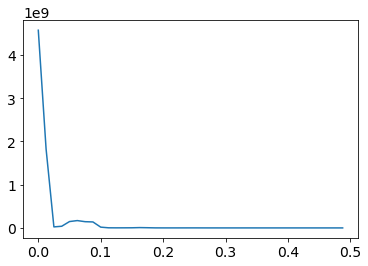

In [284]:
plt.plot(z2_tofilt_resampled.sum(['freq_x1','freq_y1']).freq_time[spec0:]*3600,z2_tofilt_resampled.sum(['freq_x1','freq_y1'])[spec0:],label='Counter-clockwise')

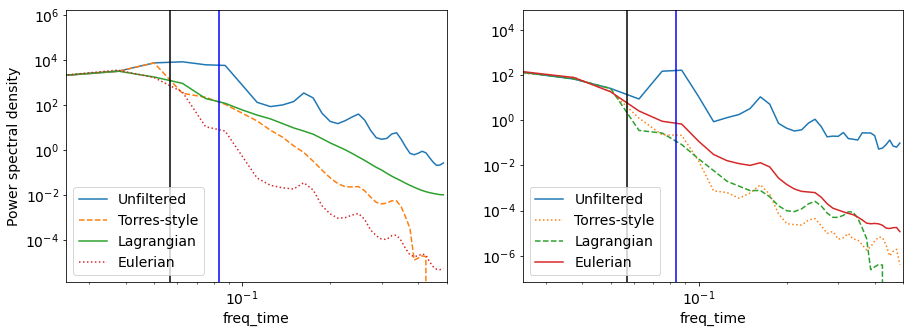

In [58]:
plt.figure(figsize=(15,5))

plt.subplot(121)

ps_iso_unfilt.sum('kr').assign_coords(freq_time=ps_iso_unfilt.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')

ps_iso_tofilt.sum('kr').assign_coords(freq_time=ps_iso_tofilt.freq_time*3600).plot(linestyle ='--')
plt.xscale('log')
plt.yscale('log')

ps_iso.sum('kr').assign_coords(freq_time=ps_iso.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')

ps_iso_eul.sum('kr').assign_coords(freq_time=ps_iso_eul.freq_time*3600).plot(linestyle =':')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.025,0.5)
plt.ylabel('Power spectral density')

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')

plt.legend(['Unfiltered','Torres-style','Lagrangian','Eulerian'])

plt.subplot(122)

eta_iso_unfilt.sum('kr').assign_coords(freq_time=ps_iso_unfilt.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')

eta_iso_eul.sum('kr').assign_coords(freq_time=ps_iso_eul.freq_time*3600).plot(linestyle =':')
plt.xscale('log')
plt.yscale('log')

eta_iso_tofilt.sum('kr').assign_coords(freq_time=ps_iso_tofilt.freq_time*3600).plot(linestyle ='--')
plt.xscale('log')
plt.yscale('log')

eta_iso.sum('kr').assign_coords(freq_time=ps_iso.freq_time*3600).plot()
plt.xscale('log')
plt.yscale('log')


plt.xlim(0.025,0.5)


plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')

plt.legend(['Unfiltered','Torres-style','Lagrangian','Eulerian'])

fig.savefig('torres-style-spectrum.png')

In [75]:
with ProgressBar():
    u2_xs_unfilt = xrft.dft(u_resampled_unfilt, dim=['x1','y1','time'],window=True).compute()
    v2_xs_unfilt = xrft.dft(v_resampled_unfilt, dim=['x1','y1','time'],window=True).compute()
    v2_xs_unfilt_nowindow = xrft.dft(v_resampled_unfilt, dim=['x1','y1','time']).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [262]:
Kdi

0.0009273009584484243

In [81]:
kx = v2_xs_unfilt.freq_x1
ky = v2_xs_unfilt.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

u2_xs_tofilt = u2_xs_unfilt
u2_xs_tofilt = u2_xs_tofilt.where(np.abs(u2_xs_tofilt.freq_time)*xr.ones_like(u2_xs_tofilt)*3600<omegaM[:,:,10]/np.pi/2)
    
v2_xs_tofilt = v2_xs_unfilt
v2_xs_tofilt = v2_xs_tofilt.where(np.abs(v2_xs_tofilt.freq_time)*xr.ones_like(v2_xs_tofilt)*3600<omegaM[:,:,10]/np.pi/2)

In [82]:
inversed_untouched = xrft.idft(v2_xs_unfilt_nowindow, dim=['freq_x1','freq_y1','freq_time']).compute()
inversed_windowed = xrft.idft(v2_xs_unfilt, dim=['freq_x1','freq_y1','freq_time'],window='hanning').compute()
u_inversed_torres_filt = xrft.idft(u2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
v_inversed_torres_filt = xrft.idft(v2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()

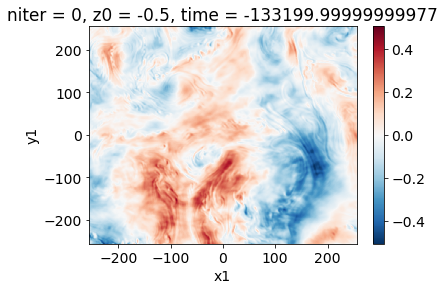

In [267]:
(inversed_untouched.isel(time=3).real).plot()

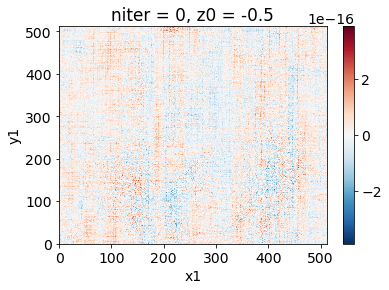

In [142]:
(v_resampled_unfilt.isel(time=3).real.drop_vars(['x1','y1'])-inversed_untouched.isel(time=3).real.drop_vars(['x1','y1'])).plot()#

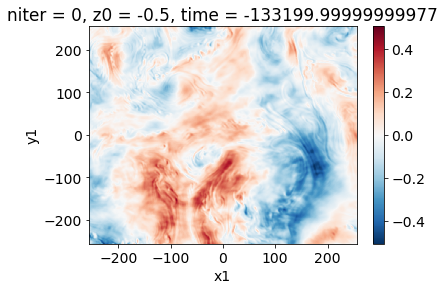

In [141]:
inversed_untouched.isel(time=3).real.plot()
#Note - need to define kr in wn space the filter along both axes at the same time. 

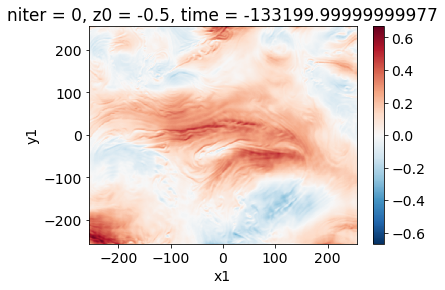

In [192]:
u_inversed_torres_filt.isel(time=3).real.plot()

In [83]:
grid1 = Grid(u_inversed_torres_filt, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

In [84]:
u_torres = grid1.interp(u_inversed_torres_filt,'X')
v_torres = grid1.interp(v_inversed_torres_filt,'Y')
u_lag = grid1.interp(u_resampled,'X')
v_lag = grid1.interp(v_resampled,'Y')
u_orig = grid1.interp(u_resampled_unfilt,'X')
v_orig = grid1.interp(v_resampled_unfilt,'Y')

In [85]:
div_orig = ((grid1.diff(u_orig.drop_vars('y1'), 'X') + grid1.diff(v_orig.drop_vars('x1'), 'Y')) / (270000*2/512))
div_torres = ((grid1.diff(u_torres, 'X') + grid1.diff(v_torres, 'Y')) / (270000*2/512))
div_lag = ((grid1.diff(u_lag.drop_vars('y1'), 'X') + grid1.diff(v_lag.drop_vars('x1'), 'Y')) / (270000*2/512))

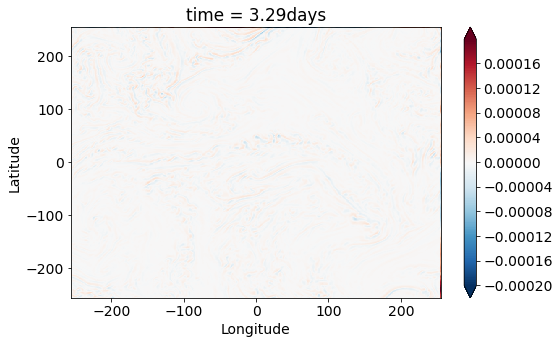

In [96]:
plt.figure(figsize=(8,5))
for tt in range(0,80):
    plt.clf()
    div_lag.isel(time=tt).plot.pcolormesh(x='x1',y='y1',levels=np.arange(-2,2,0.01)*10**-4,rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((div_lag.time.values[tt]-div_lag.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/div_lag/fig{:03d}.jpg".format(tt))

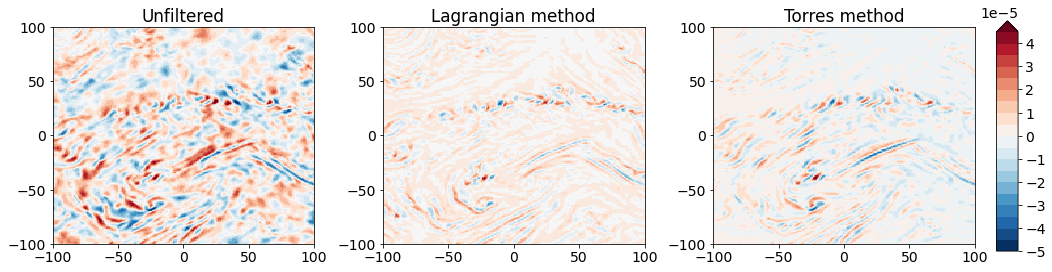

In [86]:
plt.figure(figsize=(15,4))
plt.subplot(131)
div_orig.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*5*10**-5, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Unfiltered')

plt.subplot(132)
div_lag.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*5*10**-5, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Lagrangian method')

plt.subplot(133)
cs=div_torres.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*5*10**-5, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Torres method')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('divergence.png')

In [90]:
zeta_orig = ((-grid1.diff(u_orig * 270000*2/512, 'Y') + grid1.diff(v_orig * 270000*2/512, 'X'))/1054.6**2
            ).assign_coords({"x1_g": (["x1_g"], np.arange(-256,256))}).assign_coords({"y1_g": (["y1_g"], np.arange(-256,256))})
zeta_torres = ((-grid1.diff(u_torres * 270000*2/512, 'Y') + grid1.diff(v_torres * 270000*2/512, 'X'))/1054.6**2
               ).assign_coords({"x1_g": (["x1_g"], np.arange(-256,256))}).assign_coords({"y1_g": (["y1_g"], np.arange(-256,256))})
zeta_lag = ((-grid1.diff(u_lag * 270000*2/512, 'Y') + grid1.diff(v_lag * 270000*2/512, 'X'))/1054.6**2
            ).assign_coords({"x1_g": (["x1_g"], np.arange(-256,256))}).assign_coords({"y1_g": (["y1_g"], np.arange(-256,256))})

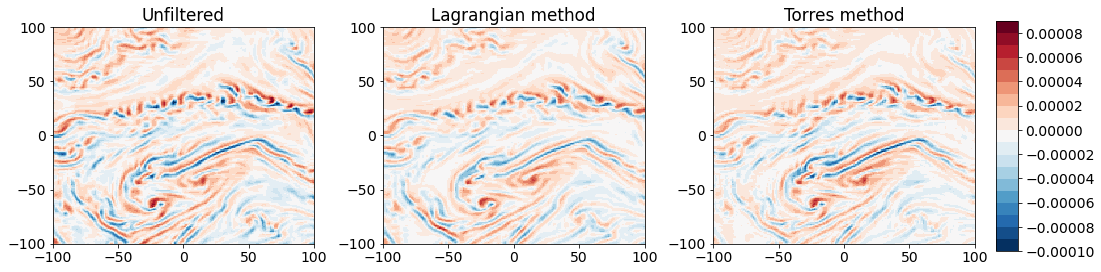

In [91]:
plt.figure(figsize=(15,4))
plt.subplot(131)
zeta_orig.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Unfiltered')

plt.subplot(132)
zeta_lag.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Lagrangian method')

plt.subplot(133)
cs=zeta_torres.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Torres method')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('zeta.png')

In [359]:
strain1_orig = ((grid.diff(u_orig.drop_vars('y1') * 270000*2/512, 'X') - grid.diff(v_orig.drop_vars('x1') * 270000*2/512, 'Y'))/1054.6**2)
strain2_orig = ((grid.diff(u_orig.drop_vars('y1') * 270000*2/512, 'Y') - grid.diff(v_orig.drop_vars('x1') * 270000*2/512, 'X'))/1054.6**2)
strain2_orig = grid.interp(grid.interp(strain2_orig, 'X'), 'Y')

strain1_torres = ((grid.diff(u_torres.drop_vars('y1') * 270000*2/512, 'X') - grid.diff(v_torres.drop_vars('x1') * 270000*2/512, 'Y'))/1054.6**2)
strain2_torres = ((grid.diff(u_torres.drop_vars('y1') * 270000*2/512, 'Y') - grid.diff(v_torres.drop_vars('x1') * 270000*2/512, 'X'))/1054.6**2)
strain2_torres = grid.interp(grid.interp(strain2_torres, 'X'), 'Y')

strain1_lag = ((grid.diff(u_lag.drop_vars('y1') * 270000*2/512, 'X') - grid.diff(v_lag.drop_vars('x1') * 270000*2/512, 'Y'))/1054.6**2)
strain2_lag = ((grid.diff(u_lag.drop_vars('y1') * 270000*2/512, 'Y') - grid.diff(v_lag.drop_vars('x1') * 270000*2/512, 'X'))/1054.6**2)
strain2_lag = grid.interp(grid.interp(strain2_lag, 'X'), 'Y')

In [360]:
strain_orig = ((strain1_orig**2+strain2_orig**2)**0.5
              ).assign_coords({"x1": (["x1"], np.arange(-256,256))}
                             ).assign_coords({"y1": (["y1"], np.arange(-256,256))})

strain_torres = ((strain1_torres**2+strain2_torres**2)**0.5
              ).assign_coords({"x1": (["x1"], np.arange(-256,256))}
                             ).assign_coords({"y1": (["y1"], np.arange(-256,256))})

strain_lag = ((strain1_lag**2+strain2_lag**2)**0.5
              ).assign_coords({"x1": (["x1"], np.arange(-256,256))}
                             ).assign_coords({"y1": (["y1"], np.arange(-256,256))})

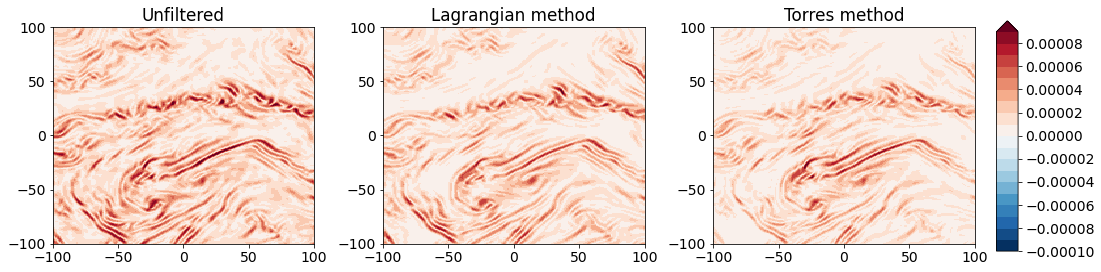

In [361]:
plt.figure(figsize=(15,4))
plt.subplot(131)
strain_orig.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Unfiltered')

plt.subplot(132)
strain_lag.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Lagrangian method')

plt.subplot(133)
cs=strain_torres.isel(time=40).real.plot.pcolormesh(levels=np.arange(-1,1,0.1)*10**-4, add_colorbar=False)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('')
plt.ylabel('')
plt.title('Torres method')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(cs, cax=cbar_ax)

#fig.savefig('zeta.png')

In [93]:
u_orig

<xarray.DataArray (time: 80, y1: 512, x1_g: 512)>
array([[[ 0.20937743,  0.31237641,  0.31757404, ...,  0.12609569,
          0.11981693,  0.11313353],
        [ 0.21611633,  0.33221663,  0.34122403, ...,  0.12343871,
          0.11693427,  0.11000821],
        [ 0.22381663,  0.35186769,  0.3653151 , ...,  0.11982958,
          0.11313064,  0.10607937],
        ...,
        [ 0.03048672,  0.15667472,  0.14783268, ..., -0.05766223,
         -0.07352125, -0.09019546],
        [ 0.04070079,  0.15296834,  0.15192038, ..., -0.03863679,
         -0.04438259, -0.06083272],
        [ 0.05196688,  0.14877811,  0.1553474 , ..., -0.03082914,
         -0.02350813, -0.02959811]],

       [[ 0.22140979,  0.33261385,  0.32989283, ...,  0.1230347 ,
          0.11849073,  0.11289248],
        [ 0.22638791,  0.35267164,  0.35376816, ...,  0.11769123,
          0.11259509,  0.10646439],
        [ 0.23262056,  0.37278302,  0.37820729, ...,  0.11184405,
          0.10607277,  0.09940391],
...
        [-0.00186367,  0.04288692,  0.02883333, ..., -0.04652577,
         -0.0466799 , -0.05147529],
        [ 0.00129001,  0.06614867,  0.0491531 , ..., -0.06590255,
         -0.06572855, -0.07024241],
        [-0.00149208,  0.08290658,  0.06621601, ..., -0.08432385,
         -0.08500251, -0.09034081]],

       [[ 0.32391978,  0.44426511,  0.45179643, ...,  0.21815505,
          0.21734382,  0.21129213],
        [ 0.32895794,  0.46007292,  0.46726969, ...,  0.21454096,
          0.21194736,  0.20528431],
        [ 0.3322254 ,  0.47351247,  0.48434275, ...,  0.20999925,
          0.20585696,  0.19900202],
        ...,
        [ 0.00956913,  0.05702125,  0.05170385, ..., -0.03248946,
         -0.03346844, -0.03847389],
        [ 0.01291269,  0.08129507,  0.07378049, ..., -0.05292472,
         -0.05404957, -0.05854766],
        [ 0.01035605,  0.09926545,  0.09355111, ..., -0.07182552,
         -0.0735484 , -0.0785405 ]]])
Coordinates:
  * time     (time) int64 3600 7200 10800 14400 ... 277200 280800 284400 288000
  * y1       (y1) int64 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
Dimensions without coordinates: x1_g

In [89]:
u_orig

<xarray.DataArray (time: 80, y1: 512, x1_g: 512)>
array([[[ 0.20937743,  0.31237641,  0.31757404, ...,  0.12609569,
          0.11981693,  0.11313353],
        [ 0.21611633,  0.33221663,  0.34122403, ...,  0.12343871,
          0.11693427,  0.11000821],
        [ 0.22381663,  0.35186769,  0.3653151 , ...,  0.11982958,
          0.11313064,  0.10607937],
        ...,
        [ 0.03048672,  0.15667472,  0.14783268, ..., -0.05766223,
         -0.07352125, -0.09019546],
        [ 0.04070079,  0.15296834,  0.15192038, ..., -0.03863679,
         -0.04438259, -0.06083272],
        [ 0.05196688,  0.14877811,  0.1553474 , ..., -0.03082914,
         -0.02350813, -0.02959811]],

       [[ 0.22140979,  0.33261385,  0.32989283, ...,  0.1230347 ,
          0.11849073,  0.11289248],
        [ 0.22638791,  0.35267164,  0.35376816, ...,  0.11769123,
          0.11259509,  0.10646439],
        [ 0.23262056,  0.37278302,  0.37820729, ...,  0.11184405,
          0.10607277,  0.09940391],
...
        [-0.00186367,  0.04288692,  0.02883333, ..., -0.04652577,
         -0.0466799 , -0.05147529],
        [ 0.00129001,  0.06614867,  0.0491531 , ..., -0.06590255,
         -0.06572855, -0.07024241],
        [-0.00149208,  0.08290658,  0.06621601, ..., -0.08432385,
         -0.08500251, -0.09034081]],

       [[ 0.32391978,  0.44426511,  0.45179643, ...,  0.21815505,
          0.21734382,  0.21129213],
        [ 0.32895794,  0.46007292,  0.46726969, ...,  0.21454096,
          0.21194736,  0.20528431],
        [ 0.3322254 ,  0.47351247,  0.48434275, ...,  0.20999925,
          0.20585696,  0.19900202],
        ...,
        [ 0.00956913,  0.05702125,  0.05170385, ..., -0.03248946,
         -0.03346844, -0.03847389],
        [ 0.01291269,  0.08129507,  0.07378049, ..., -0.05292472,
         -0.05404957, -0.05854766],
        [ 0.01035605,  0.09926545,  0.09355111, ..., -0.07182552,
         -0.0735484 , -0.0785405 ]]])
Coordinates:
  * time     (time) int64 3600 7200 10800 14400 ... 277200 280800 284400 288000
  * y1       (y1) int64 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
Dimensions without coordinates: x1_g